This notebook will proceed to read in data from three sources:
1. FRED GDP data, using the PANDAS interface
2. ATUS sleep data, in a csv file
3. NASS CDS Data, in SAS format
I proceed to describe these data and the methods used to clean, describe, and visualize it.

In [1]:
%matplotlib inline
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## FRED Data

We begin by immporting data from the Federal Reserve Economic Data (FRED) database. Luckily, pandas_datareader has a lovely interface for bringing in data directly from the website. All you need is the code corresponding to the data you want. In this case, we will be looking at GDP from 2003 to 2016. The code for this is 'GDP.'

In [2]:
start = datetime.datetime(2003, 1, 1)
end = datetime.datetime(2016, 12, 31)
GDP = web.DataReader(["GDP"], "fred", start, end)
GDP.isnull().any()
GDP.head()

,GDP
DATE,
2003-01-01,11230.078
2003-04-01,11370.653
2003-07-01,11625.137
2003-10-01,11816.827
2004-01-01,11988.403


So, it looks like everything read in correctly. Let's view it graphically to view how GDP has changed over time. I am very interested in what was going on around 2007-2010, the time period leading up to the recession through the beginning of the recovery:

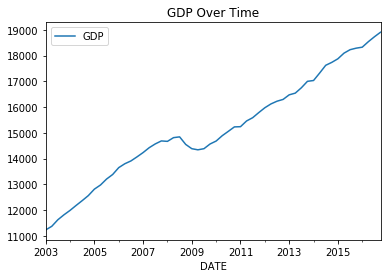

In [3]:
GDP.plot(title="GDP Over Time")

So, you can definitely tell where the recession hit - GDP decreased for a small time. But, it may be sort of hard to work with this data as is. I would love to have data that just shows how much cyclicality there is in the data - I want to take out the overall upward trend in GDP to see what is left over.
There are several ways to do this. One would be to fit a line to the data, and then subtract off the predicted values of the line. A more complicated solution would be to fit some higher-order polynomial to the data and then subtract off the predicted values. Basically, I want to split the data into a trend component and a cyclic component, but I don't want the trend component to follow the data 'too closely.'
Luckily, there is a method for this - the HP filter. The HP filter uses an algorithm which tries to maximize the 'closeness' of the data to the trend component, but there is also a penalty for fitting the data too closely. This penalty is imbibed in a parameter called $\lambda$.
I now will detrend the data in order to see its cyclicality. Let's start out with a $\lambda$ value of 800.
From here on out, 'GDPcy' will be the cyclical part of the data, and 'GDPtr' will be the trend component.

In [4]:
import statsmodels.api as sm

/home/robert/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


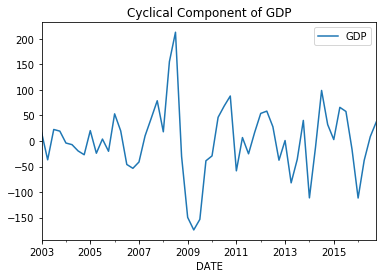

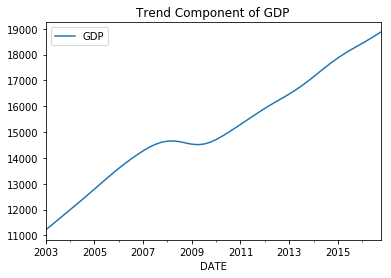

In [5]:
GDPcy, GDPtr = sm.tsa.filters.hpfilter(GDP, 15)
GDPcy.plot(title="Cyclical Component of GDP")
GDPtr.plot(title="Trend Component of GDP")

It looks like the trend component, the second graph, includes a bit of the downturn of the recession. Let's try a much higher $\lambda$ value:

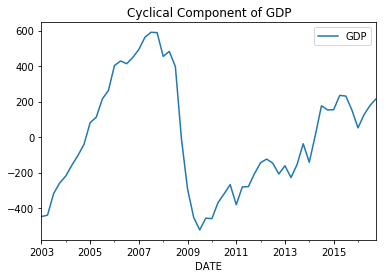

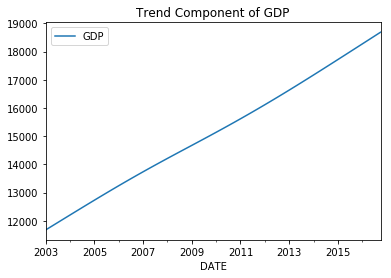

In [6]:
GDPcy, GDPtr = sm.tsa.filters.hpfilter(GDP, 15000)
GDPcy.plot(title="Cyclical Component of GDP")
GDPtr.plot(title="Trend Component of GDP")

Now it seems that the trend component is just a straight line. Most economists agree that something about GDP growth has changed since the Great Recession - it has slowed down, maybe permanently. This is referred to as hysteresis - a permanent effect caused by a temporary downturn. We will use a $\lambda$ value of 1600, which is actually standard for quarterly data.

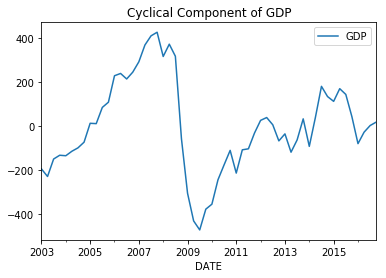

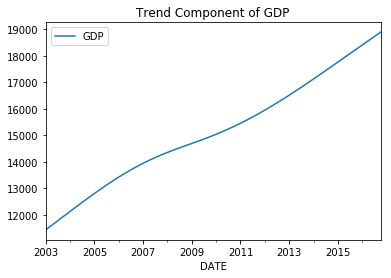

In [7]:
GDPcy, GDPtr = sm.tsa.filters.hpfilter(GDP, 1600)
GDPcy.plot(title="Cyclical Component of GDP")
GDPtr.plot(title="Trend Component of GDP")

We can see that some change in trend is accounted for in the trend part of the data, while it is still the cyclic component that captures the majority of the downturn. From here on out, we will mostly ignor the trend component of the data. We only are interested in the cyclical aspect.

## ATUS Data
I will now read in data from the American Time Use Survey (ATUS) which I have in a .csv file. The ATUS sureveys over 10,000 individuals a year about how they spent their time over the last 24-hour period. There are detailed activity codes for household chores, education, work, leisure, and sleep.
I have averages by quarter for sleep (split on employment status), time spent trying to fall asleep (sleeplessness), and the ratio of sleeplessness to sleep, as well as 4-period moving averages for these variables.

Of specific interest is the 4-quarter moving average of the ratio of sleeplessness to total sleep. I read a paper that stated that recessions bring health benefits. Although people work less, they end up sleeping more. This is well-documented. But, what if people's sleep quality is negatively effected? It would throw in doubt the conclusion of the paper. I will compare this moving average with GDP to see if sleep quality varies over the business cycle.

In [8]:
sleep = pd.read_csv('sleep.csv')
sleep.set_index(GDP.index.values, inplace=True)
del sleep['quarterID']
sleep.head()

,"ratio of sleeplessness to sleep, restricted, male","ratio of sleeplessness to sleep, restriced, female","ratio, male","ratio, female","ratio, both sexes",moving average,sleepft,productionft,hworkft,leisureft,countft,sleeppt,productionpt,hworkpt,leisurept,countpt,sleepnw,hworknw,leisurenw,countnw
2003-01-01,0.189777,0.183535,0.002457,0.003587,0.003110,NaN,499.451874,314.097382,214.236206,405.708252,2629,524.561523,200.528214,241.612152,464.285095,691,544.299988,278.834625,570.105469,1820
2003-04-01,0.193247,0.136695,0.002724,0.003626,0.003227,NaN,501.091522,299.975250,215.608398,417.289185,2666,522.288757,194.748215,258.534851,457.147949,703,547.429077,269.237061,584.476379,1776
2003-07-01,0.192785,0.156716,0.003057,0.004124,0.003651,NaN,505.597412,294.301849,221.937820,413.772125,2541,531.366150,206.783463,249.660110,442.952759,762,550.774841,265.556274,570.019775,1821
2003-10-01,0.197545,0.207914,0.002624,0.005672,0.004331,0.003580,505.531158,302.122314,206.775009,415.448486,2649,531.098755,196.968964,252.520447,444.761627,709,557.024597,250.272919,579.682007,1953
2004-01-01,0.094883,0.163241,0.002408,0.006382,0.004639,0.003962,501.312256,299.528381,217.607742,416.492249,1550,528.006714,208.778519,242.753922,450.230438,447,551.775269,262.263947,581.163757,1148


Let's take a look at the sleeplessness ratio in graphical form:

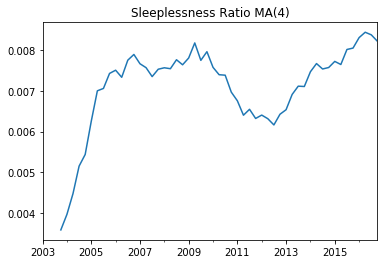

In [9]:
sleep['moving average'].plot(title="Sleeplessness Ratio MA(4)")

This looks interesting. If people are losing sleep because of the recession, I would expect sleeplessness to be highest from 2008-2009, when it was at its height. That's about what we're seeing. Let's look at the ATUS data and the GDP cycilcal data together:

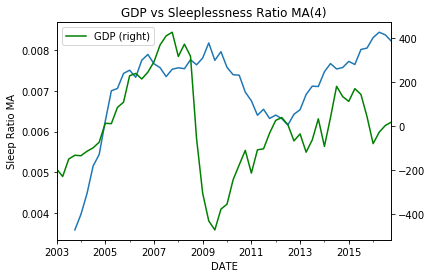

In [10]:
#all = pd.concat([GDPcy, sleep['moving average']], axis=1, join_axes=[GDP.index])
ax = sleep['moving average'].plot()
ax.set_ylabel('Sleep Ratio MA')
GDPcy.plot(secondary_y=True, style='g', ax=ax, title="GDP vs Sleeplessness Ratio MA(4)")

It's a little ambiguous as to whether the sleeplessness ratio is procyclical or counter-cyclical. At a glance, it seems that sleeplessness was highest during the low point of the recession. But, from 2012 onwards, it seems that sleeplessness is moving up without being able to explain that with a downturn in GDP. So, we run the numbers using another function which will calculate various business cycle moments. I now write a function to calculate business cycle moments. Let's get some hard numbers, and see what those tell us.

In [11]:
def calcmom(data, means = False, stds = True, relstds = True, 
            corrs = True, autos = True, cvars = False):
    '''
    This function calculates a user controlled set of moments from data
    It takes the following as inputs:
    1)  data: an nobs-by-nvar matrix ofdata with with nobs indexing the 
        time-series observations in rows and nvar indexing the variables in 
        columns.  If GDP is included it should be in the first column.
    
    The function caculates and returns the following outputs in a single
    matrix with  rows for each type of momemnt and nvar columns .  The moments,
    if calculated are reported in the following order.  Each column can be
    turned off or on by setting the appropriate flags.
    1) means -     means of the variables
    2) stdevs -    standard deviations of variables
    3) relstds -   standard deviations of variables relative to GDP
    4) correls -   correlations of variables with GDP
    5) autocoors - autocorrelations of variables
    6) coefvars -  coefficients of variation (stdev/mean)
        
    Notes:
   
    '''
    (nobs, nvar) = data.shape
    report = np.zeros(nvar)
    count = 0
    rindex = []
    
    if means or cvars:
        dmeans= np.mean(data,axis=0)
        report = np.vstack((report,dmeans))
        count = count + 1
        rindex.extend(['means'])
        
    if stds or cvars:
        dstds = np.std(data,axis=0)
        report = np.vstack((report,dstds))
        count = count + 1
        rindex.extend(['standard deviations'])
        
    if relstds:
        drelstds = dstds/dstds[0]
        report = np.vstack((report,drelstds))
        count = count + 1
        rindex.extend(['standard deviations relative to GDP'])
        
    if corrs:
        temp = np.corrcoef(np.transpose(data))
        dcorrs = temp[0:nvar,0]
        report = np.vstack((report,dcorrs))
        count = count + 1
        rindex.extend(['correlations with GDP'])
        
    if autos:
        dlead = np.transpose(data[1:nobs,:])
        dlag = np.transpose(data[0:nobs-1,:])
        temp = np.corrcoef(dlead,dlag)
        dautos = np.diag(temp, -nvar)
        report = np.vstack((report,dautos))
        count = count + 1
        rindex.extend(['autocorrelations'])
        
    if cvars:
        dcvars = dstds/dmeans
        report = np.vstack((report,dcvars))
        count = count + 1
        rindex.extend(['coefficients of variation'])
        
    # appropriately truncate lists
    report = report[1:count+1,:]
    rindex = rindex[0:count+1]
    return report, rindex

In [12]:
arraydata=np.asarray([GDPcy['GDP'][3:], sleep['moving average'][3:]]) #Get rid of first 3 NaNs in Moving Average
arraydata=arraydata.transpose()
report, rindex = calcmom(arraydata, stds=True, relstds=True, corrs=True, autos=True)
print(report, rindex)

[[  2.08939472e+02   1.03662377e-03]
 [  1.00000000e+00   4.96135920e-06]
 [  1.00000000e+00   1.88182117e-01]
 [  9.01049565e-01   9.65128089e-01]] ['standard deviations', 'standard deviations relative to GDP', 'correlations with GDP', 'autocorrelations']


The left column is GDP, and the right column is the sleeplessness moving average.
Autocorrelations are the following: if you were to model time-series data in the following form:

$y_t = \rho y_{t-1} + \epsilon_t$

with $\epsilon_t$ being i.i.d. with mean 0, what would be the best estimate for $\rho$?
So, the autocorrelations (bottom row) are interesting. I would expect a moving average to have this high autocorrelation, given that a moving average from one period has to be correlated with a moving average from the previous period. It makes sense that the cyclical part of GDP is persistent as well. GDP is a slow-moving beast.
The most interesting thing here is the correlation with GDP, the [3,2] element of report. It seems that sleeplessness is slightly procyclical, which is not quite what I expected to see. Maybe recessions help people to sleep. I'm a little skeptical, so let's try to filter the ratio differently. Let's use an HP filter instead of a moving average, and see if that has an effect. I'll use a lambda value that is much smaller than 1600 since the cyclicality of sleeplessness should vary by season

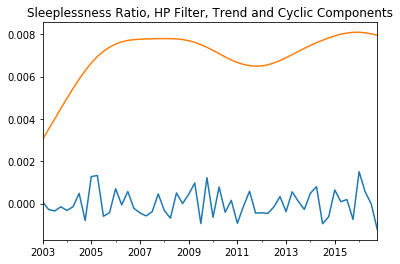

In [13]:
sleeplesscy, sleeplesstr = sm.tsa.filters.hpfilter(sleep['ratio, both sexes'], 100)
sleeplesscy.plot(title="Sleeplessness Ratio, HP Filter, Trend and Cyclic Components")
sleeplesstr.plot()

That looks good. The most important thing is that the cyclical part of the data has mean 0. Let's graph it alongside GDP.

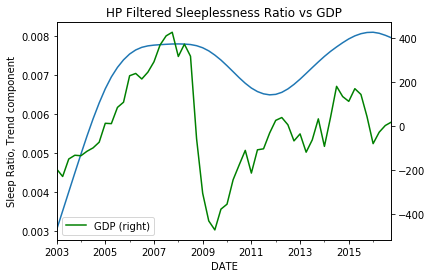

In [14]:
ax = sleeplesstr.plot()
ax.set_ylabel('Sleep Ratio, Trend component')
GDPcy.plot(secondary_y=True, style='g', ax=ax, title="HP Filtered Sleeplessness Ratio vs GDP")

So, that's what it looks like. Let's see what the numbers come out to be.

In [15]:
arraydata=np.asarray([GDPcy['GDP'], sleeplesscy]) #Get rid of first 3 NaNs in Moving Average
arraydata=arraydata.transpose()
report, rindex = calcmom(arraydata, stds=True, relstds=True, corrs=True, autos=True)
print(report, rindex)

[[  2.08440351e+02   6.31497052e-04]
 [  1.00000000e+00   3.02962958e-06]
 [  1.00000000e+00  -1.28307531e-01]
 [  9.04053728e-01  -2.18727213e-01]] ['standard deviations', 'standard deviations relative to GDP', 'correlations with GDP', 'autocorrelations']


We see that the sleeplessness ratio is slightly anticyclical - meaning sleeplessness increases while GDP decreases. This is about what I expected to see.

## NASS CDS data
These data come from the governments. The NASS CDS consists of detailed data on automobile accidents, including information on injuries sustained and determined causes of the accident. I will be looking at crash data from 2009 specifically. I am most interested in the amount of accidents cause by drowsy driving.

In [16]:
crashes = pd.read_sas('gv.sas7bdat', format='sas7bdat')
crashes.head()

,ACCSEQDV,ACCTYPE,ALCTEST,ANGTHIS,ANGOTHER,AOPSVEH,WEATHER,BAGDEPFV,BAGDEPOV,BAREQSP,...,WGTCDTR,VEHTYPE,WHLDRWHL,DAYRUNLT,otvehwgt,otbdytyp,VINJSER,VINJURED,VTREAT,VAIS
0,1.0,51.0,NaN,180.0,355.0,0.0,0.0,0.0,0.0,23.0,...,1.0,b'T',44.0,b'N',123.0,3.0,0.0,1.0,0.0,1.0
1,1.0,50.0,NaN,355.0,180.0,1.0,0.0,0.0,0.0,36.0,...,NaN,b'P',NaN,b'N',148.0,14.0,1.0,2.0,4.0,3.0
2,3.0,6.0,NaN,998.0,998.0,1.0,0.0,2.0,0.0,NaN,...,NaN,b'P',NaN,b'N',998.0,98.0,1.0,1.0,3.0,3.0
3,2.0,71.0,NaN,120.0,90.0,1.0,0.0,1.0,0.0,NaN,...,NaN,b'P',NaN,b'N',NaN,68.0,0.0,2.0,4.0,1.0
4,NaN,70.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,8.0,b'T',64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is quite messy, and there is a lot of missing data. I only need the DRIVDIST variable, which contains data on whether the cause of the accident was some sort of distraction. The values are given as float64, but the coding manual says they are integers. I will recode missing values to an arbitrary integer, then make sure all the values are integers in the data.

In [17]:
crashes['DRIVDIST'] = crashes['DRIVDIST'].fillna(value=100) #Set missing values to 100
crashes['DRIVDIST'] = crashes['DRIVDIST'].astype(int)
#crashes['DRIVDIST'] = crashes['DRIVDIST'].astype('category')

Let's look at frequencies of causes of distraction:

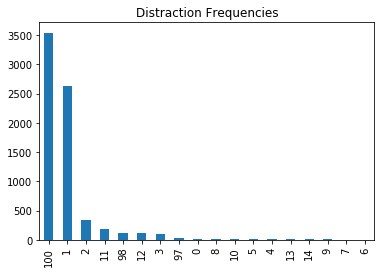

In [18]:
crashes['DRIVDIST'].value_counts().plot(kind='bar', title="Distraction Frequencies")

I know from the documentation that the value 100 (formerly NaN) signifies that distraction was not the cause of the accident, or the data was missing. A 1 signifies that an occupant distracting the driver caused the crash; a 2 signifies that it was a moving object in the vehicle, and an 11 signifies drowsiness on the part of the driver. Let's recode this categorically, along with the other variables, and then represent it as a pie chart:

/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


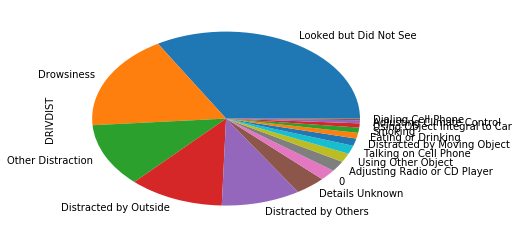

In [19]:
recodedict = {"DRIVDIST" : {100:"Unknown", 1:"Not Distracted", 2:"Looked but Did Not See", 3:"Distracted by Others", \
                        4:"Distracted by Moving Object", 5:"Talking on Cell Phone", 6:"Dialing Cell Phone", \
                        7:"Adjusting Climate Control", 8:"Adjusting Radio or CD Player", 9:"Using Object Integral to Car", \
                        10:"Using Other Object", 11:"Drowsiness", 12:"Distracted by Outside", 13:"Eating or Drinking", \
                        14:"Smoking", 97:"Details Unknown", 98:"Other Distraction"}}
crashes.replace(recodedict, inplace=True)
crashes[crashes.DRIVDIST!="Unknown"][crashes.DRIVDIST!="Not Distracted"]['DRIVDIST'].value_counts().plot.pie() #Restrict to known causes

Well, there's your drowsy driving. I'd like try and use drowsy driving accidents as a proxy measure for sleep quality, but I lack the data to do so. I do think it's funny how many accidents seem to be caused by people who looked for risks, but simply didn't see them. It's a little scary. I'm also a little skeptical as to how well you can determine the cause of distraction. It's possible that someone who looked but did not see was drowsy, that being the cause for not seeing.